In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score


from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import plotly.express as px

In [2]:
df = pd.read_csv('Stroke_Prediction.csv')

In [3]:
df.head()

,ID,Gender,Age_In_Days,Hypertension,Heart_Disease,Ever_Married,Type_Of_Work,Residence,Avg_Glucose,BMI,Smoking_Status,Stroke
0,31153,Male,1104.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30650,Male,21204.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,17412,Female,2928.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,57008,Female,25578.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46657,Male,5128.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              43400 non-null  int64  
 1   Gender          43400 non-null  object 
 2   Age_In_Days     43400 non-null  float64
 3   Hypertension    43400 non-null  int64  
 4   Heart_Disease   43400 non-null  int64  
 5   Ever_Married    43400 non-null  object 
 6   Type_Of_Work    43400 non-null  object 
 7   Residence       43400 non-null  object 
 8   Avg_Glucose     43400 non-null  float64
 9   BMI             41938 non-null  float64
 10  Smoking_Status  30108 non-null  object 
 11  Stroke          43400 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


In [5]:
df.set_index('ID', inplace=True)

In [6]:
df["Gender"] = df["Gender"].replace(["Male", "Female"], [0, 1])
df["Ever_Married"] = df["Ever_Married"].replace(["Yes", "No"], [1, 0])




In [7]:
df['Age_in_years'] = df['Age_In_Days'] / 365.25

In [8]:
df.drop(columns='Age_In_Days',inplace=True)

In [9]:
df.isna().sum()

Gender                0
Hypertension          0
Heart_Disease         0
Ever_Married          0
Type_Of_Work          0
Residence             0
Avg_Glucose           0
BMI                1462
Smoking_Status    13292
Stroke                0
Age_in_years          0
dtype: int64

In [10]:
df['missing'] = df['Smoking_Status'].isna()

In [11]:
df.dropna(subset=['BMI'], inplace=True)

In [12]:
df.shape

(41938, 12)

In [13]:
df = df[(df['Age_in_years']>=0) & (df['Age_in_years'] <= 100)]

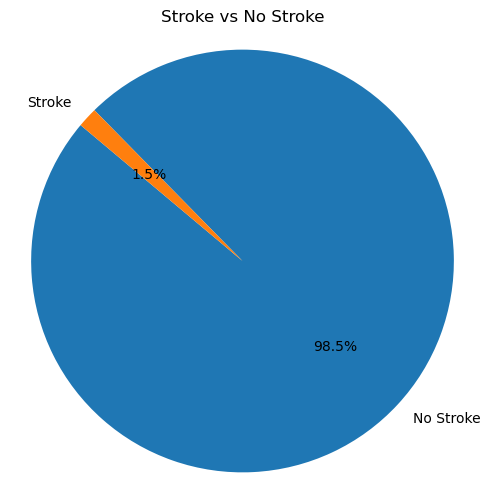

In [14]:
counts = df['Stroke'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=['No Stroke','Stroke'], autopct='%1.1f%%', startangle=140)
plt.axis('equal') 
plt.title("Stroke vs No Stroke")

plt.show()

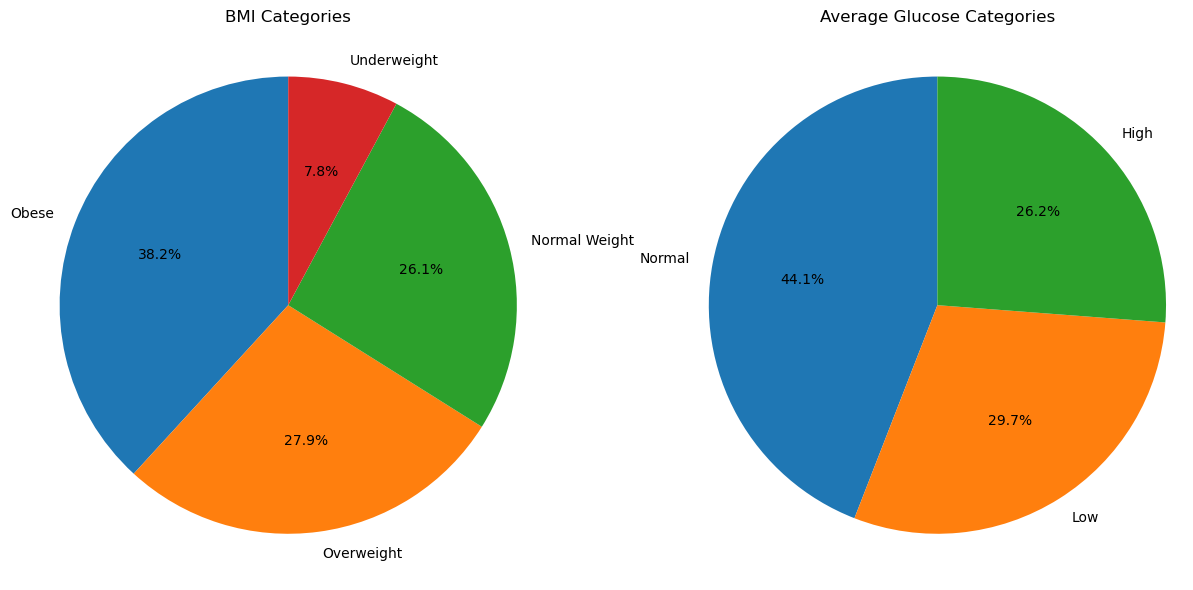

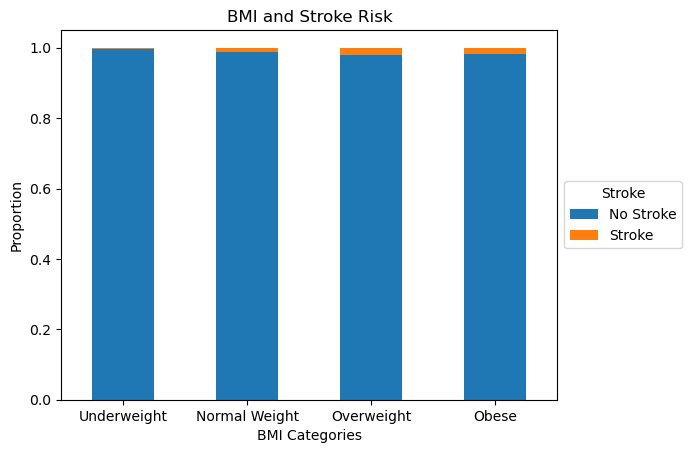

In [15]:
bmi_categories = ['Underweight', 'Normal Weight', 'Overweight', 'Obese']
bmi_thresholds = [0, 18.5, 24.9, 29.9, 100]

bmi_groups = pd.cut(df['BMI'], bins=bmi_thresholds, labels=bmi_categories)
bmi_stroke_counts = df.groupby(bmi_groups)['Stroke'].value_counts(normalize=True).unstack(fill_value=0)


glucose_categories = ['Low', 'Normal', 'High']
glucose_thresholds = [0, 80, 110, 300]

bmi_counts = pd.cut(df['BMI'], bins=bmi_thresholds, labels=bmi_categories).value_counts()
bmi_percentages = (bmi_counts / bmi_counts.sum()) * 100

glucose_counts = pd.cut(df['Avg_Glucose'], bins=glucose_thresholds, labels=glucose_categories).value_counts()
glucose_percentages = (glucose_counts / glucose_counts.sum()) * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.pie(bmi_percentages, labels=bmi_percentages.index, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
ax1.set_title('BMI Categories')

ax2.pie(glucose_percentages, labels=glucose_percentages.index, autopct='%1.1f%%', startangle=90)
ax2.axis('equal')
ax2.set_title('Average Glucose Categories')

plt.tight_layout()
plt.show()

ax = bmi_stroke_counts.plot(kind='bar', stacked=True)
ax.set_xlabel('BMI Categories')
ax.set_ylabel('Proportion')
ax.set_title('BMI and Stroke Risk')
plt.legend(title='Stroke', labels=['No Stroke', 'Stroke'], loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation=0)
plt.show()

In [16]:
gender_stroke_counts = df.groupby('Gender')['Stroke'].value_counts(normalize=True).unstack(fill_value=0)
print("Stroke Prevalence by Gender:")
print(gender_stroke_counts)

Stroke Prevalence by Gender:
Stroke         0         1
Gender                    
0       0.983161  0.016839
1       0.985687  0.014313
Other   1.000000  0.000000


In [17]:
hypertension_heart_disease_counts = df.groupby(['Hypertension', 'Heart_Disease'])['Stroke'].value_counts(normalize=True).unstack(fill_value=0)
print("Stroke Prevalence by Hypertension and Heart Disease:")
print(hypertension_heart_disease_counts)

Stroke Prevalence by Hypertension and Heart Disease:
Stroke                             0         1
Hypertension Heart_Disease                    
0            0              0.990055  0.009945
             1              0.923473  0.076527
1            0              0.959019  0.040981
             1              0.910913  0.089087


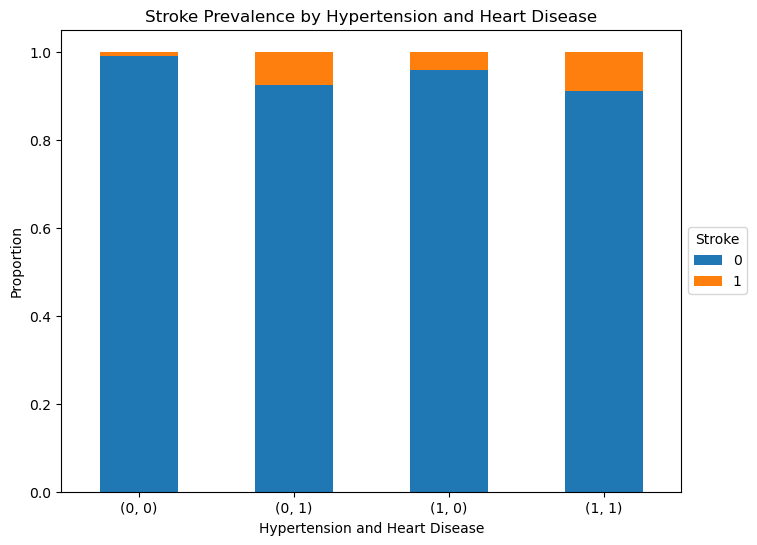

In [18]:
hypertension_heart_disease_counts = df.groupby(['Hypertension', 'Heart_Disease'])['Stroke'].value_counts(normalize=True).unstack(fill_value=0)

ax = hypertension_heart_disease_counts.plot(kind='bar', stacked=True, figsize=(8, 6))

ax.set_xlabel('Hypertension and Heart Disease')
ax.set_ylabel('Proportion')
ax.set_title('Stroke Prevalence by Hypertension and Heart Disease')
plt.legend(title='Stroke', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation=0)

plt.show()

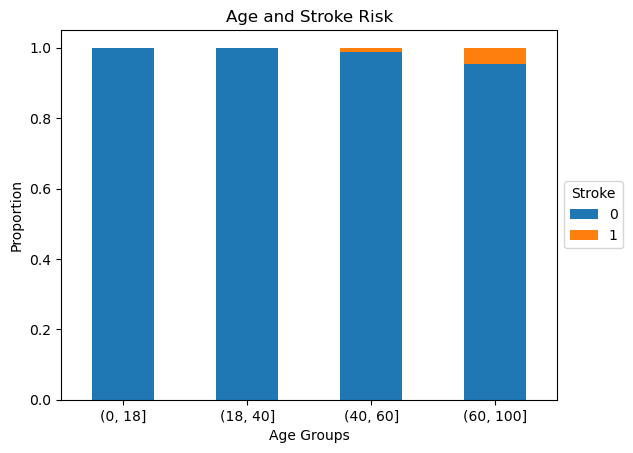

In [19]:
age_groups = pd.cut(df['Age_in_years'], [0, 18, 40, 60, 100])

age_stroke_counts = df.groupby(age_groups)['Stroke'].value_counts(normalize=True).unstack(fill_value=0)

ax = age_stroke_counts.plot(kind='bar', stacked=True)
ax.set_xlabel('Age Groups')
ax.set_ylabel('Proportion')
ax.set_title('Age and Stroke Risk')
plt.legend(title='Stroke', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation=0)
plt.show()

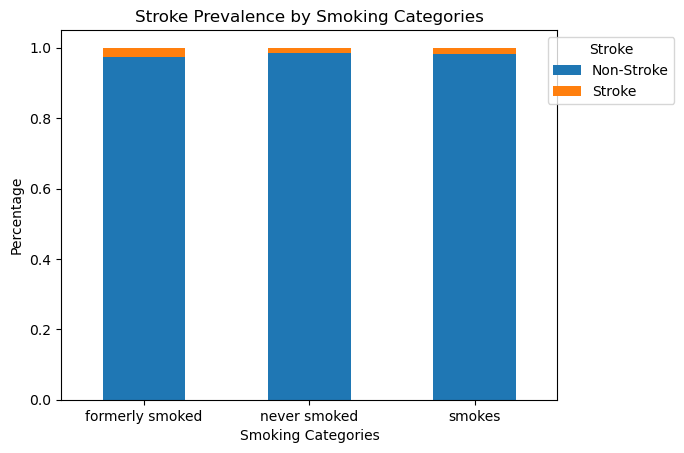

In [20]:
smoking_counts = df.groupby('Smoking_Status')['Stroke'].value_counts(normalize=True).unstack(fill_value=0)

ax = smoking_counts.plot(kind='bar', stacked=True)
ax.set_xlabel('Smoking Categories')
ax.set_ylabel('Percentage')
ax.set_title('Stroke Prevalence by Smoking Categories')

plt.legend(title='Stroke', labels=['Non-Stroke', 'Stroke'], loc='upper right', bbox_to_anchor=(1.25, 1))

plt.xticks(rotation=0)
plt.show()

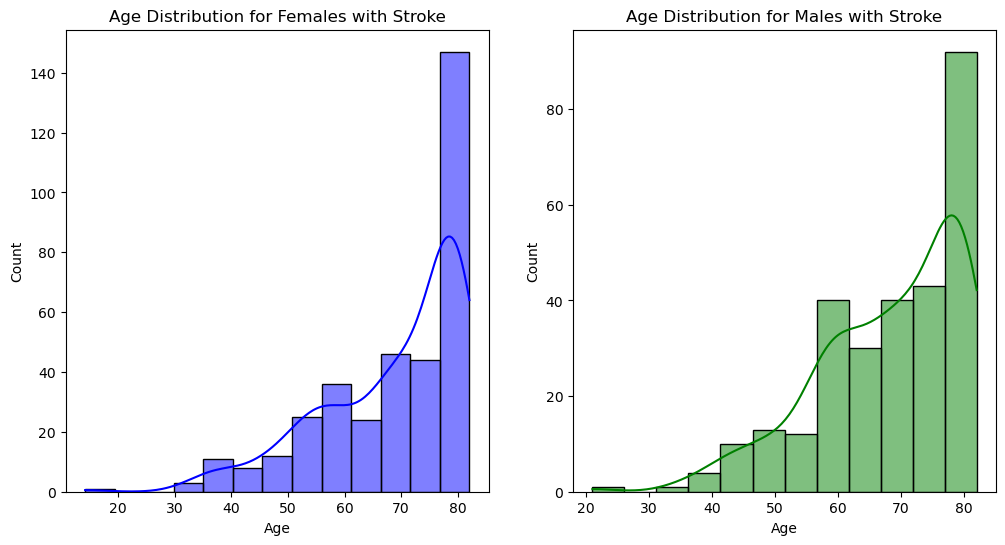

In [21]:
stroke_data = df[df['Stroke'] == 1]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(data=stroke_data[stroke_data['Gender'] == 1], x='Age_in_years', kde=True, color='blue', ax=axes[0])
axes[0].set_title('Age Distribution for Females with Stroke')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')

sns.histplot(data=stroke_data[stroke_data['Gender'] == 0], x='Age_in_years', kde=True, color='green', ax=axes[1])
axes[1].set_title('Age Distribution for Males with Stroke')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Count')

plt.show()

/var/folders/g9/n9dpfw1d3pjf7dqwrht5y8h40000gn/T/ipykernel_33051/402379622.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


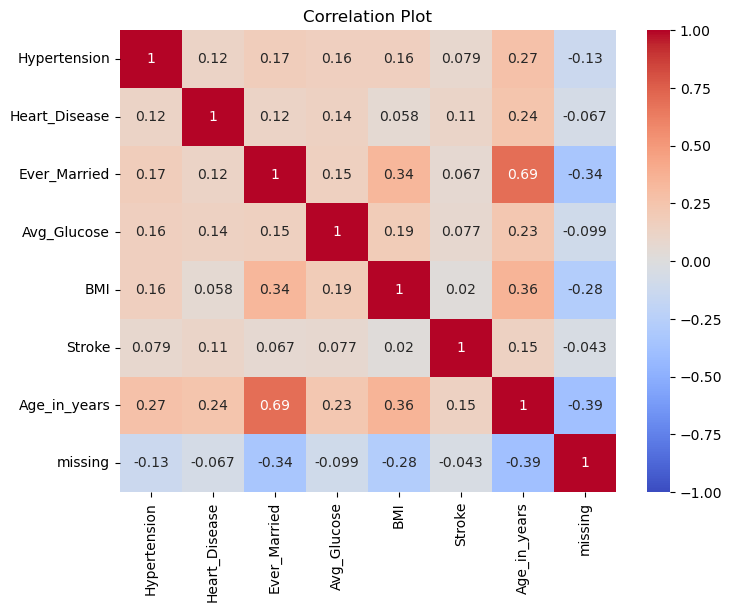

In [22]:
corr_matrix = df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Plot')

plt.show()

/var/folders/g9/n9dpfw1d3pjf7dqwrht5y8h40000gn/T/ipykernel_33051/2037401952.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['Stroke'] == 0][column], label='No Stroke', shade=True)
/var/folders/g9/n9dpfw1d3pjf7dqwrht5y8h40000gn/T/ipykernel_33051/2037401952.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['Stroke'] == 1][column], label='Stroke', shade=True)


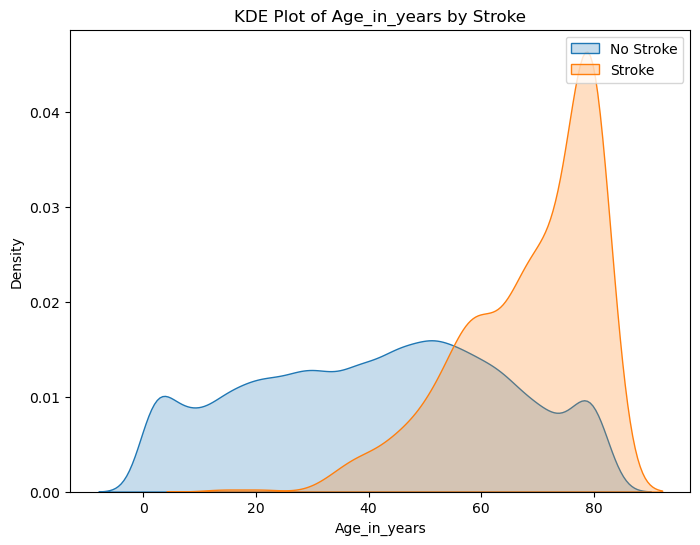

/var/folders/g9/n9dpfw1d3pjf7dqwrht5y8h40000gn/T/ipykernel_33051/2037401952.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['Stroke'] == 0][column], label='No Stroke', shade=True)
/var/folders/g9/n9dpfw1d3pjf7dqwrht5y8h40000gn/T/ipykernel_33051/2037401952.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['Stroke'] == 1][column], label='Stroke', shade=True)


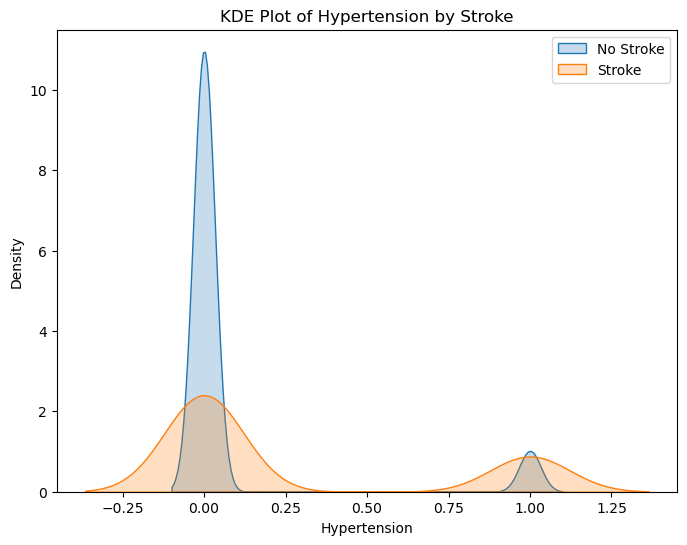

/var/folders/g9/n9dpfw1d3pjf7dqwrht5y8h40000gn/T/ipykernel_33051/2037401952.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['Stroke'] == 0][column], label='No Stroke', shade=True)
/var/folders/g9/n9dpfw1d3pjf7dqwrht5y8h40000gn/T/ipykernel_33051/2037401952.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['Stroke'] == 1][column], label='Stroke', shade=True)


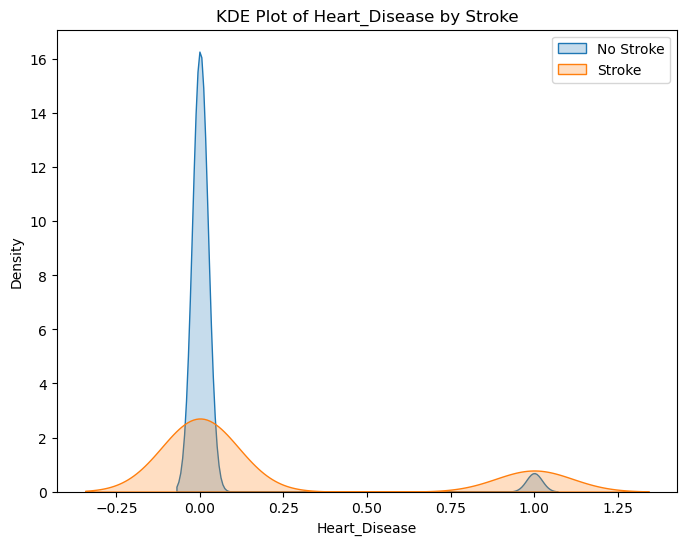

/var/folders/g9/n9dpfw1d3pjf7dqwrht5y8h40000gn/T/ipykernel_33051/2037401952.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['Stroke'] == 0][column], label='No Stroke', shade=True)
/var/folders/g9/n9dpfw1d3pjf7dqwrht5y8h40000gn/T/ipykernel_33051/2037401952.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['Stroke'] == 1][column], label='Stroke', shade=True)


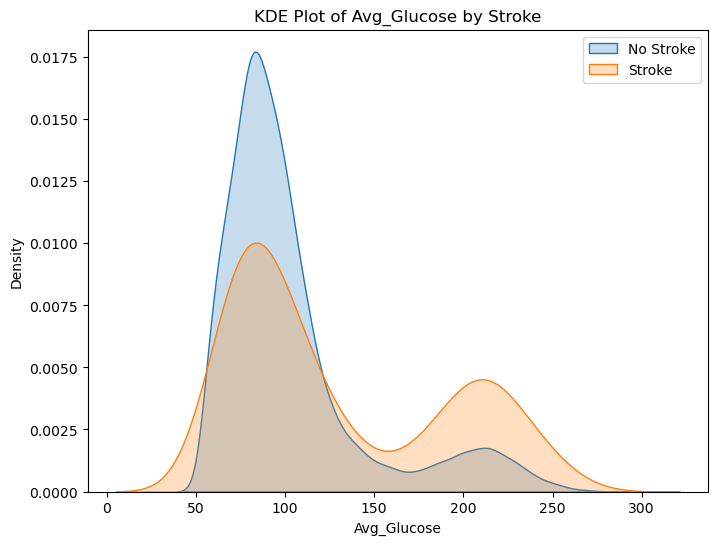

/var/folders/g9/n9dpfw1d3pjf7dqwrht5y8h40000gn/T/ipykernel_33051/2037401952.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['Stroke'] == 0][column], label='No Stroke', shade=True)
/var/folders/g9/n9dpfw1d3pjf7dqwrht5y8h40000gn/T/ipykernel_33051/2037401952.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['Stroke'] == 1][column], label='Stroke', shade=True)


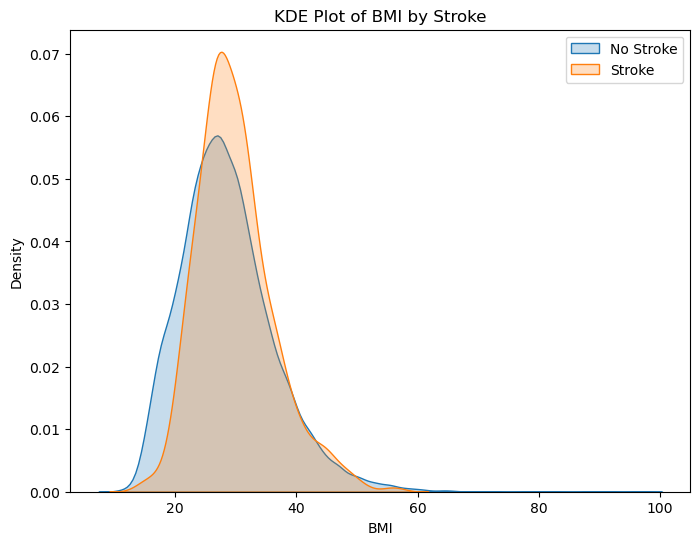

In [23]:
continuous_columns = ['Age_in_years', 'Hypertension','Heart_Disease',
                     'Avg_Glucose', 'BMI']

for column in continuous_columns:
    plt.figure(figsize=(8, 6))
    sns.kdeplot(df[df['Stroke'] == 0][column], label='No Stroke', shade=True)
    sns.kdeplot(df[df['Stroke'] == 1][column], label='Stroke', shade=True)
    plt.title(f'KDE Plot of {column} by Stroke')
    plt.legend()
    plt.show()

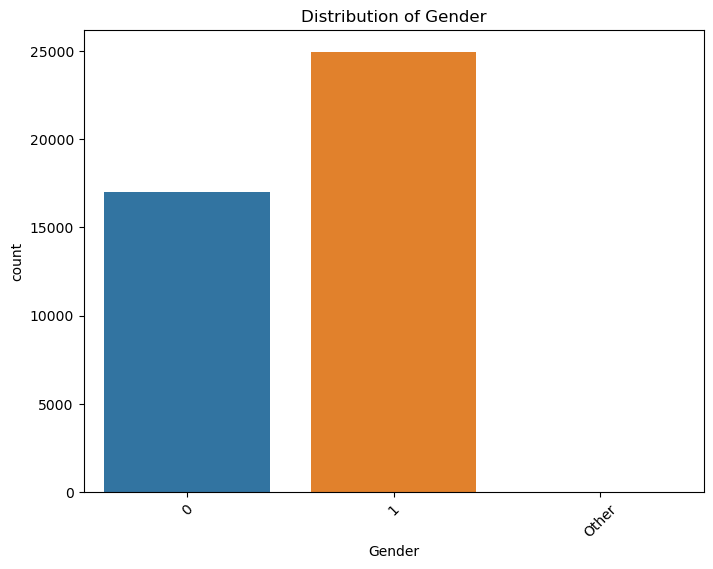

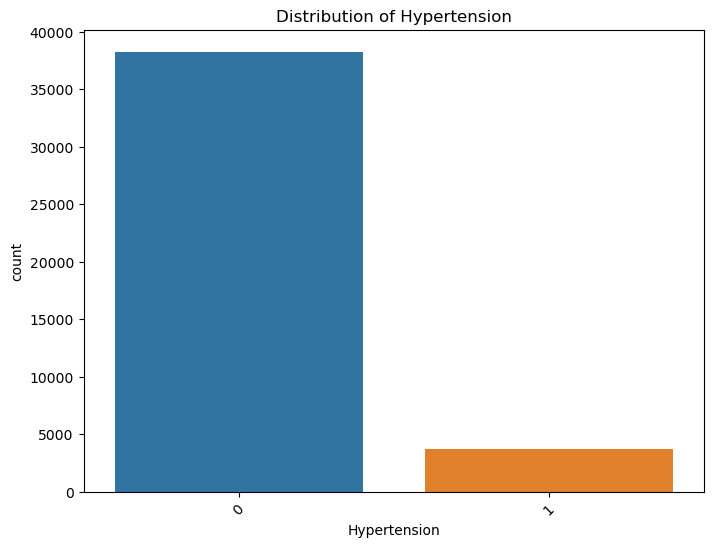

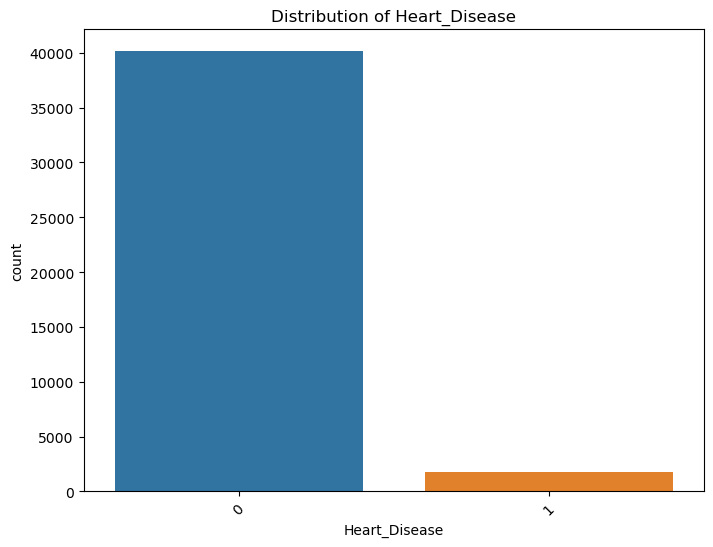

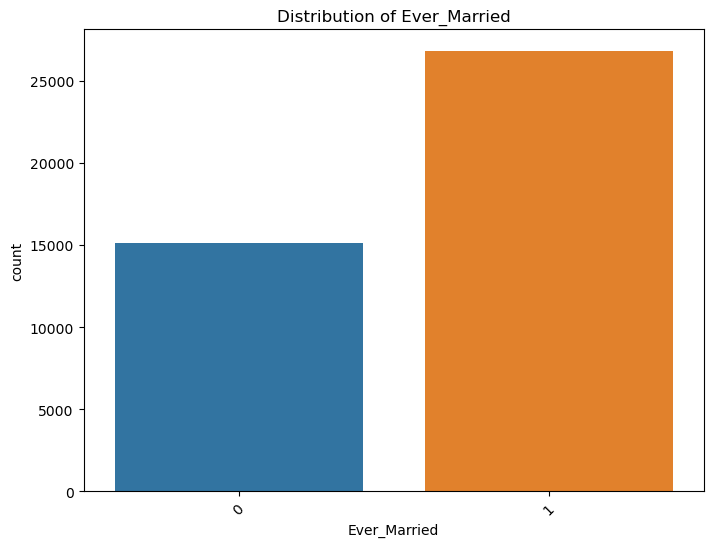

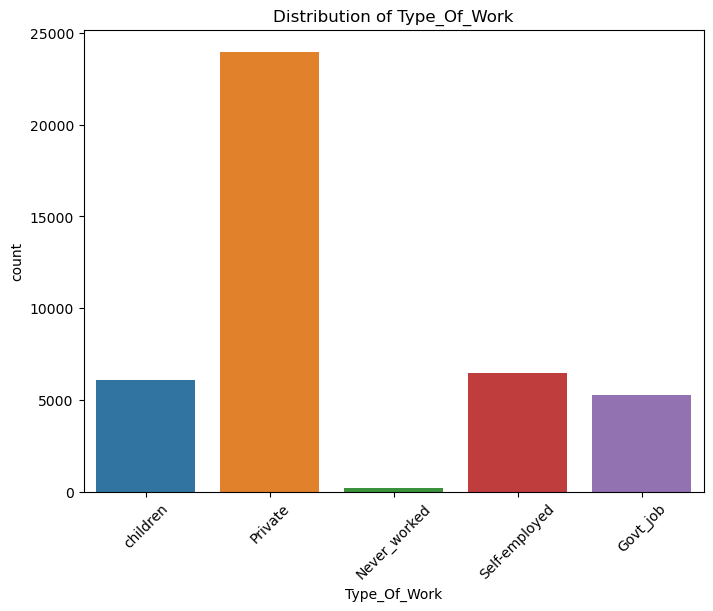

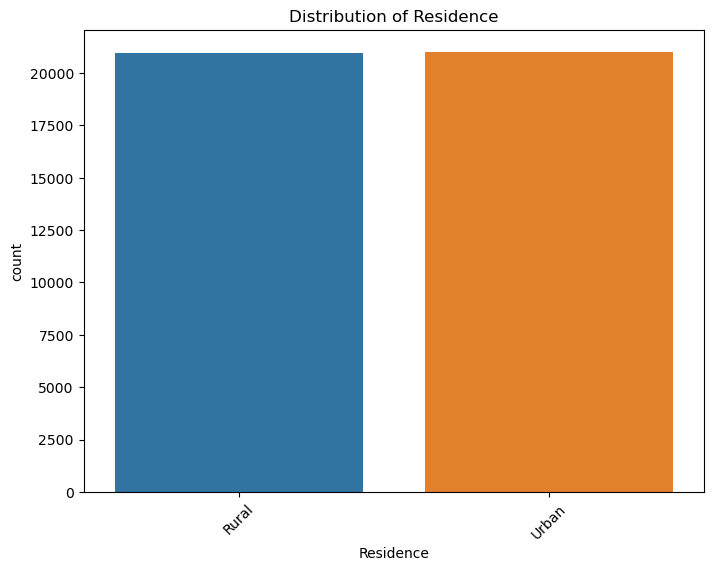

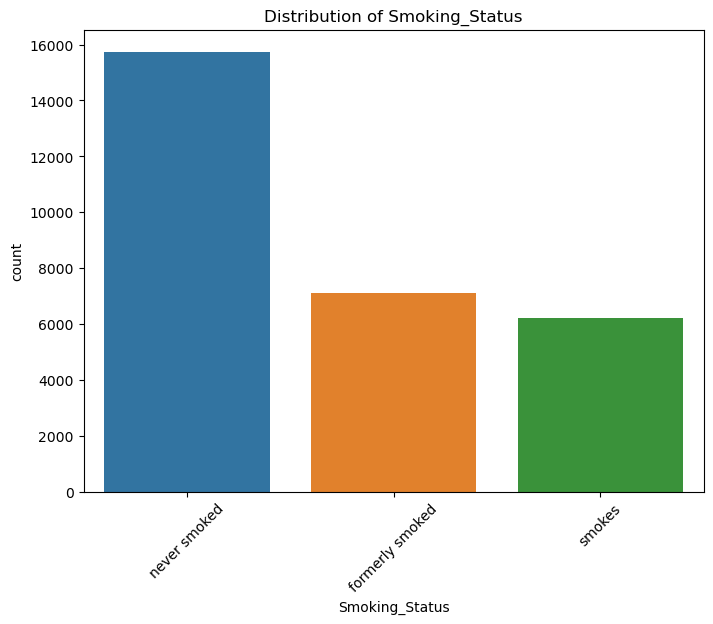

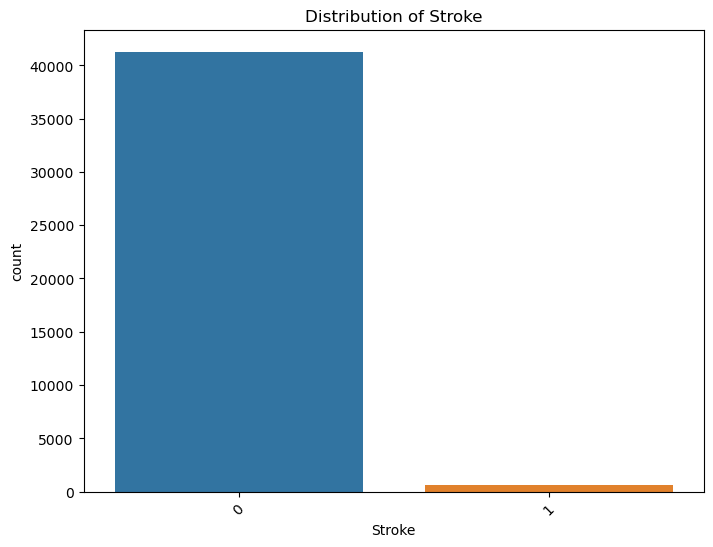

In [24]:
categorical_cols = ['Gender', 'Hypertension', 'Heart_Disease', 'Ever_Married', 'Type_Of_Work', 'Residence', 'Smoking_Status', 'Stroke']
for col in categorical_cols:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x=col)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()

In [25]:
df = df[df['Gender']!='Other']

Text(0.5, 0.98, 'Feature Distribution')

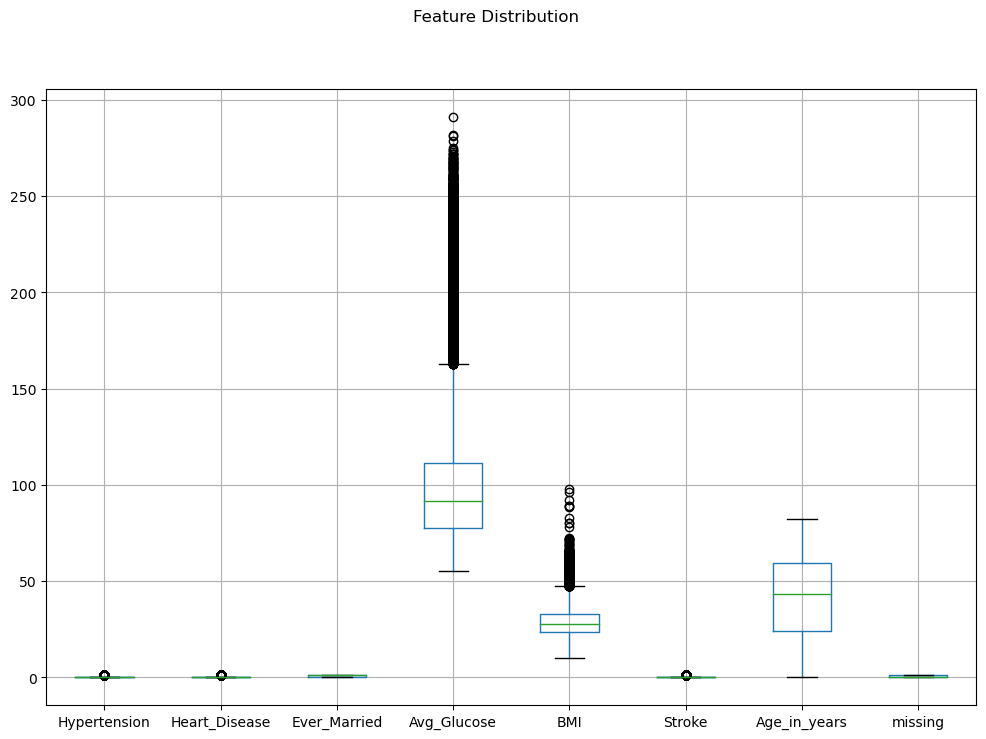

In [26]:
df.boxplot(figsize = (12, 8))
plt.suptitle("Feature Distribution")

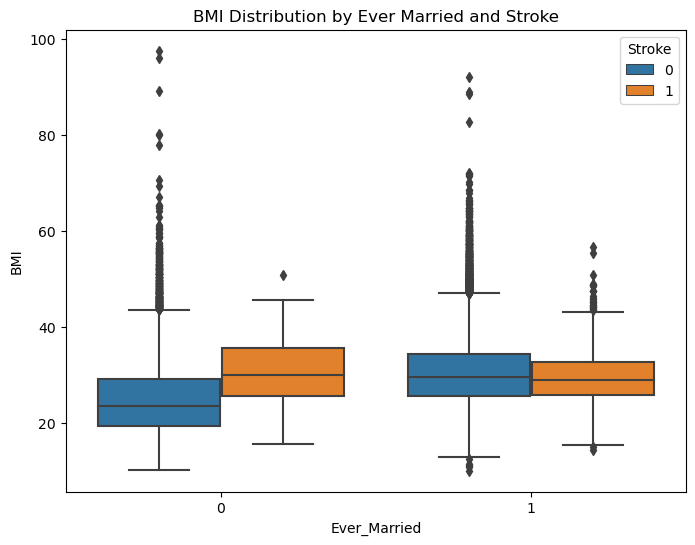

In [27]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Ever_Married', y='BMI', data=df, hue='Stroke')
plt.title('BMI Distribution by Ever Married and Stroke')
plt.show()

/var/folders/g9/n9dpfw1d3pjf7dqwrht5y8h40000gn/T/ipykernel_33051/1513452813.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Hypertension', y='Stroke', data=df, ci=None)


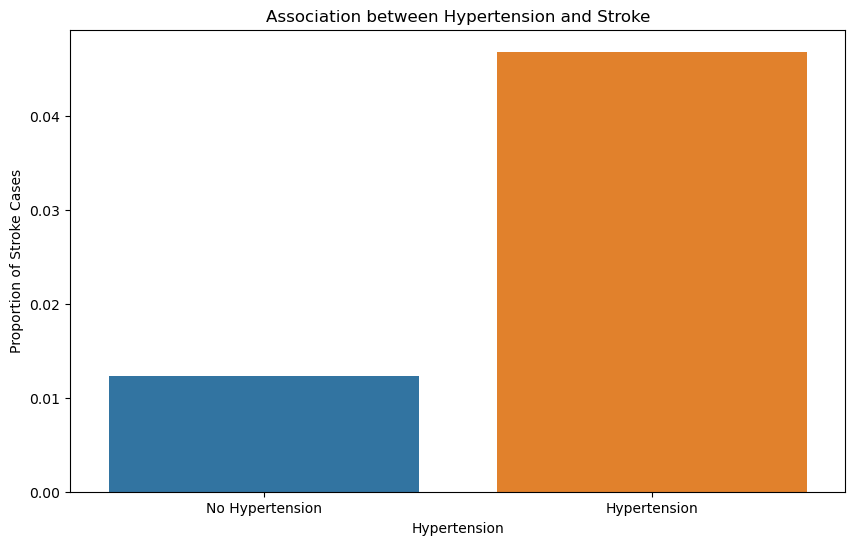

/var/folders/g9/n9dpfw1d3pjf7dqwrht5y8h40000gn/T/ipykernel_33051/1513452813.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Heart_Disease', y='Stroke', data=df, ci=None)


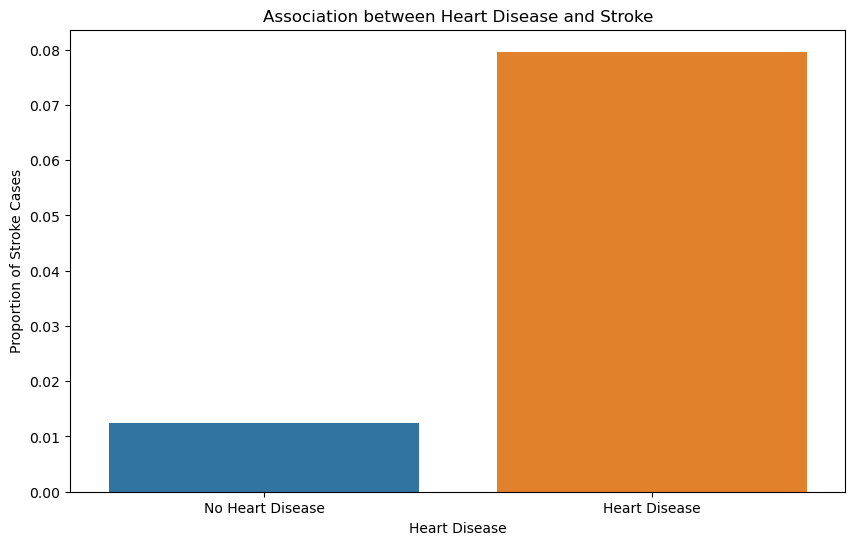

In [28]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Hypertension', y='Stroke', data=df, ci=None)
plt.title('Association between Hypertension and Stroke')
plt.xlabel('Hypertension')
plt.ylabel('Proportion of Stroke Cases')
plt.xticks([0, 1], ['No Hypertension', 'Hypertension'])

plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Heart_Disease', y='Stroke', data=df, ci=None)
plt.title('Association between Heart Disease and Stroke')
plt.xlabel('Heart Disease')
plt.ylabel('Proportion of Stroke Cases')
plt.xticks([0, 1], ['No Heart Disease', 'Heart Disease'])

plt.show()






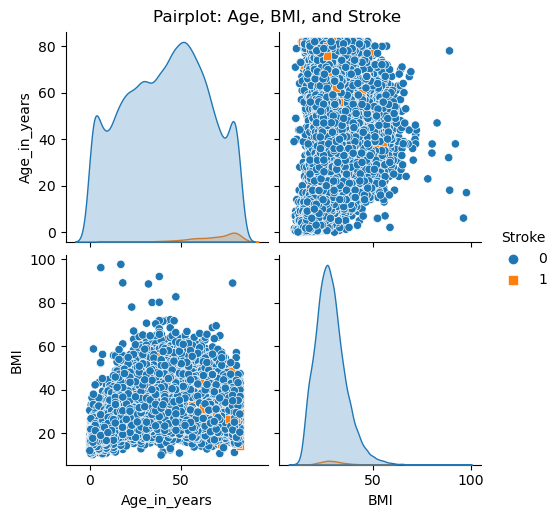

In [29]:
age_bmi_correlation = df['Age_in_years'].corr(df['BMI'])

age_stroke_correlation = df['Age_in_years'].corr(df['Stroke'])
bmi_stroke_correlation = df['BMI'].corr(df['Stroke'])

sns.pairplot(df, vars=['Age_in_years', 'BMI'], hue='Stroke', markers=["o", "s"])
plt.suptitle('Pairplot: Age, BMI, and Stroke', y=1.02)
plt.show()

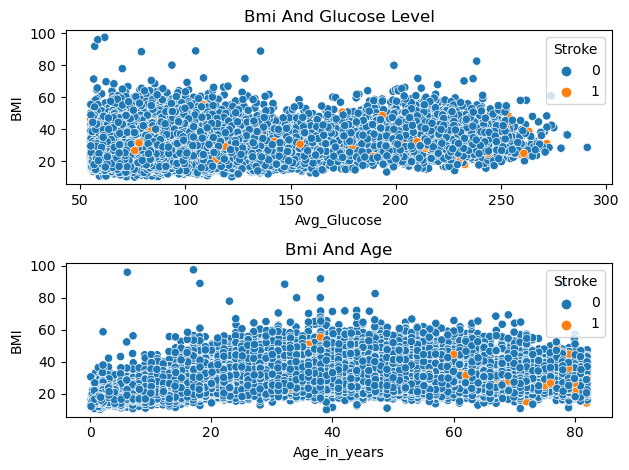

In [30]:
plt.subplot(2,1,1)
plt.title('Bmi And Glucose Level')
sns.scatterplot(x=df['Avg_Glucose'],y=df['BMI'],hue=df['Stroke'])
plt.subplot(2,1,2)
plt.title('Bmi And Age')
sns.scatterplot(x=df['Age_in_years'],y=df['BMI'],hue=df['Stroke'])
plt.tight_layout()
plt.show()

/var/folders/g9/n9dpfw1d3pjf7dqwrht5y8h40000gn/T/ipykernel_33051/541372716.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Gender', y='Heart_Disease', hue='Stroke', data=df, ci=None, dodge=True)


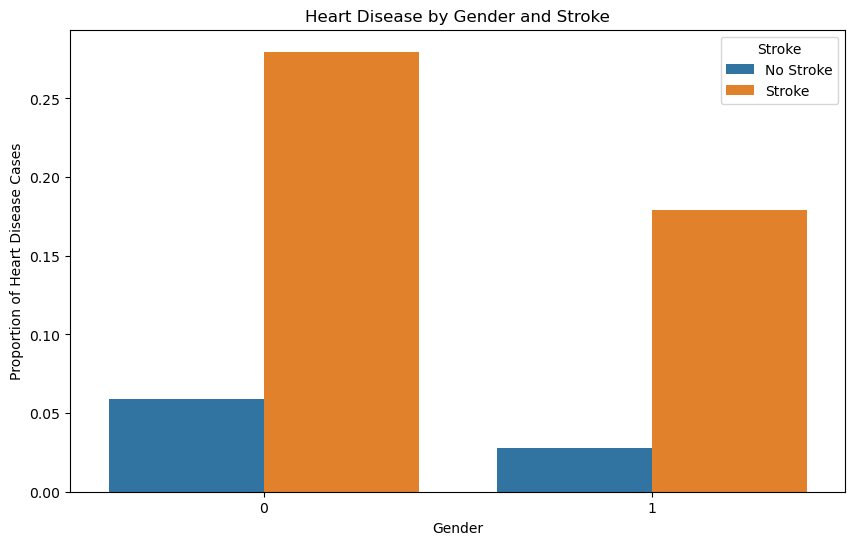

In [31]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Gender', y='Heart_Disease', hue='Stroke', data=df, ci=None, dodge=True)
plt.title('Heart Disease by Gender and Stroke')
plt.xlabel('Gender')
plt.ylabel('Proportion of Heart Disease Cases')
plt.legend(title='Stroke', labels=['No Stroke', 'Stroke'])

plt.show()

/var/folders/g9/n9dpfw1d3pjf7dqwrht5y8h40000gn/T/ipykernel_33051/1721667531.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Gender', y='Hypertension', hue='Stroke', data=df, ci=None, dodge=True)


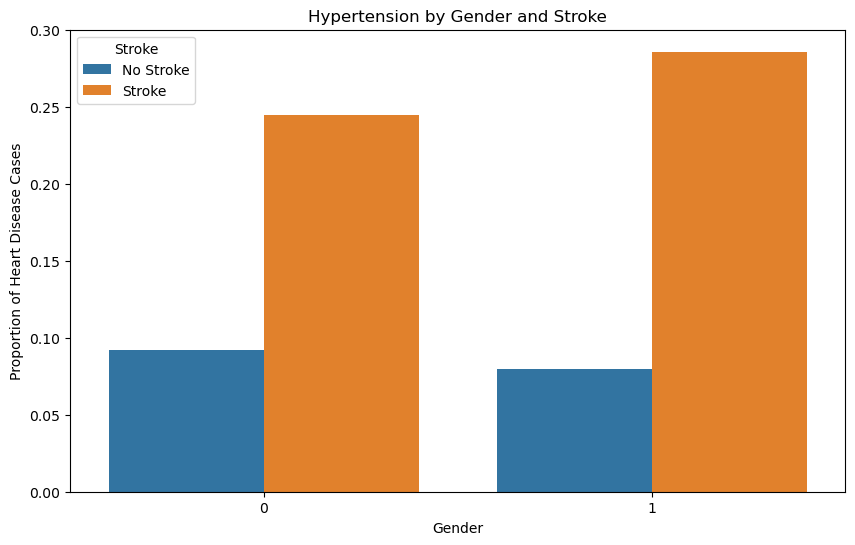

In [32]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Gender', y='Hypertension', hue='Stroke', data=df, ci=None, dodge=True)
plt.title('Hypertension by Gender and Stroke')
plt.xlabel('Gender')
plt.ylabel('Proportion of Heart Disease Cases')
plt.legend(title='Stroke', labels=['No Stroke', 'Stroke'])

plt.show()

In [33]:
df.head()

,Gender,Hypertension,Heart_Disease,Ever_Married,Type_Of_Work,Residence,Avg_Glucose,BMI,Smoking_Status,Stroke,Age_in_years,missing
ID,,,,,,,,,,,,
31153,0,0,0,0,children,Rural,95.12,18.0,NaN,0,3.022587,True
30650,0,1,0,1,Private,Urban,87.96,39.2,never smoked,0,58.053388,False
17412,1,0,0,0,Private,Urban,110.89,17.6,NaN,0,8.016427,True
57008,1,0,0,1,Private,Rural,69.04,35.9,formerly smoked,0,70.028747,False
46657,0,0,0,0,Never_worked,Rural,161.28,19.1,NaN,0,14.039699,True


In [34]:
df_modeling = df.copy()

In [35]:
columns_to_encode = ['Type_Of_Work','Residence', 'Smoking_Status', 'missing']
df_modeling = pd.get_dummies(df, columns=columns_to_encode, prefix=columns_to_encode)

In [36]:
df_modeling.head()

,Gender,Hypertension,Heart_Disease,Ever_Married,Avg_Glucose,BMI,Stroke,Age_in_years,Type_Of_Work_Govt_job,Type_Of_Work_Never_worked,Type_Of_Work_Private,Type_Of_Work_Self-employed,Type_Of_Work_children,Residence_Rural,Residence_Urban,Smoking_Status_formerly smoked,Smoking_Status_never smoked,Smoking_Status_smokes,missing_False,missing_True
ID,,,,,,,,,,,,,,,,,,,,
31153,0,0,0,0,95.12,18.0,0,3.022587,0,0,0,0,1,1,0,0,0,0,0,1
30650,0,1,0,1,87.96,39.2,0,58.053388,0,0,1,0,0,0,1,0,1,0,1,0
17412,1,0,0,0,110.89,17.6,0,8.016427,0,0,1,0,0,0,1,0,0,0,0,1
57008,1,0,0,1,69.04,35.9,0,70.028747,0,0,1,0,0,1,0,1,0,0,1,0
46657,0,0,0,0,161.28,19.1,0,14.039699,0,1,0,0,0,1,0,0,0,0,0,1


In [37]:
scaler = StandardScaler()
columns = ["Avg_Glucose", "BMI", "Age_in_years"]
df_stand = df_modeling.copy()
df_stand[columns] = scaler.fit_transform(df_stand[columns])
df_stand.head()

,Gender,Hypertension,Heart_Disease,Ever_Married,Avg_Glucose,BMI,Stroke,Age_in_years,Type_Of_Work_Govt_job,Type_Of_Work_Never_worked,Type_Of_Work_Private,Type_Of_Work_Self-employed,Type_Of_Work_children,Residence_Rural,Residence_Urban,Smoking_Status_formerly smoked,Smoking_Status_never smoked,Smoking_Status_smokes,missing_False,missing_True
ID,,,,,,,,,,,,,,,,,,,,
31153,0,0,0,0,-0.201675,-1.364930,0,-1.729531,0,0,0,0,1,1,0,0,0,0,0,1
30650,0,1,0,1,-0.371211,1.363497,0,0.719672,0,0,1,0,0,0,1,0,1,0,1,0
17412,1,0,0,0,0.171729,-1.416410,0,-1.507275,0,0,1,0,0,0,1,0,0,0,0,1
57008,1,0,0,1,-0.819201,0.938789,0,1.252648,0,0,1,0,0,1,0,1,0,0,1,0
46657,0,0,0,0,1.364872,-1.223361,0,-1.239203,0,1,0,0,0,1,0,0,0,0,0,1


In [38]:
df_stand['Gender'] = df_stand['Gender'].astype(int)

In [39]:
eval_df = df_stand[['Gender', 'Hypertension', 'Heart_Disease', 'Ever_Married',
       'Avg_Glucose', 'BMI', 'Stroke', 'Age_in_years', 'Type_Of_Work_Govt_job',
       'Type_Of_Work_Never_worked', 'Type_Of_Work_Private',
       'Type_Of_Work_Self-employed', 'Type_Of_Work_children',
       'Residence_Rural', 'Residence_Urban', 'Smoking_Status_formerly smoked',
       'Smoking_Status_never smoked', 'Smoking_Status_smokes', 'missing_False',
       'missing_True']].sample(int(df_stand.shape[0] * 0.2), random_state=42)
train_df = df_stand.drop(index=eval_df.index)

X, y = train_df.drop(columns=['Stroke']), train_df['Stroke']
X_eval, y_eval = eval_df.drop(columns=['Stroke']), eval_df['Stroke']

oversample = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = oversample.fit_resample(X, y)

usampled_df = X_resampled.copy()
usampled_df['Stroke'] = y_resampled

X_eval_resampled, y_eval_resampled = oversample.fit_resample(X_eval, y_eval)
usampled_eval_df = X_eval_resampled.copy()
usampled_eval_df['Stroke'] = y_eval_resampled

In [40]:
dt = Pipeline(steps = [('model',DecisionTreeClassifier(random_state=42))])
random = Pipeline(steps = [('model',RandomForestClassifier(random_state=42))])
logistic = Pipeline(steps = [('model',LogisticRegression(random_state=42))])

X = usampled_df.drop('Stroke', axis=1)
Y = usampled_df['Stroke']

x_eval = usampled_eval_df.drop('Stroke', axis=1)
y_eval = usampled_eval_df['Stroke']
holdout_x = X.sample(100)
holdout_y = Y.loc[X.index]

X = X.drop(index=holdout_x.index)
Y = Y.drop(index=holdout_x.index)



In [41]:
dt_cross = cross_val_score(dt,X,Y,cv=5,scoring='f1')
random_cross = cross_val_score(random,X,Y,cv=5,scoring='f1')
logistic_cross = cross_val_score(logistic,X,Y,cv=5,scoring='f1')

/Users/helen/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/helen/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

In [42]:
print(dt_cross.mean())
print(random_cross.mean())
print(logistic_cross.mean())

0.9271563214388688
0.9707060038435943
0.8372139726098304


In [43]:
dt.fit(X,Y)
random.fit(X,Y)
logistic.fit(X,Y)

X = df_stand.loc[:,X.columns]
Y = df_stand.loc[:,'Stroke']

dt_pred   = dt.predict(x_eval)
random_pred   =random.predict(x_eval)
logistic_pred   = logistic.predict(x_eval)

dt_cm = confusion_matrix(y_eval,dt_pred)
random_cm = confusion_matrix(y_eval,random_pred)
logistic_cm = confusion_matrix(y_eval,logistic_pred)

dt_f1  = f1_score(y_eval,dt_pred )
random_f1  = f1_score(y_eval,random_pred )
logistic_f1  = f1_score(y_eval,logistic_pred )

print(dt_f1)
print(random_f1)
print(logistic_f1)

/Users/helen/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7993028556106718
0.5559463986599665
0.8600628033114474


In [44]:
precision = precision_score(y_eval,dt_pred)
recall = recall_score(y_eval,dt_pred)

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.8969459906724838
Recall: 0.7208318220287753


In [45]:
precision = precision_score(y_eval,random_pred)
recall = recall_score(y_eval,random_pred)

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.904606159716544
Recall: 0.40128158626526417


In [46]:
precision = precision_score(y_eval,random_pred)
recall = recall_score(y_eval,logistic_pred)

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.904606159716544
Recall: 0.9106516745254504


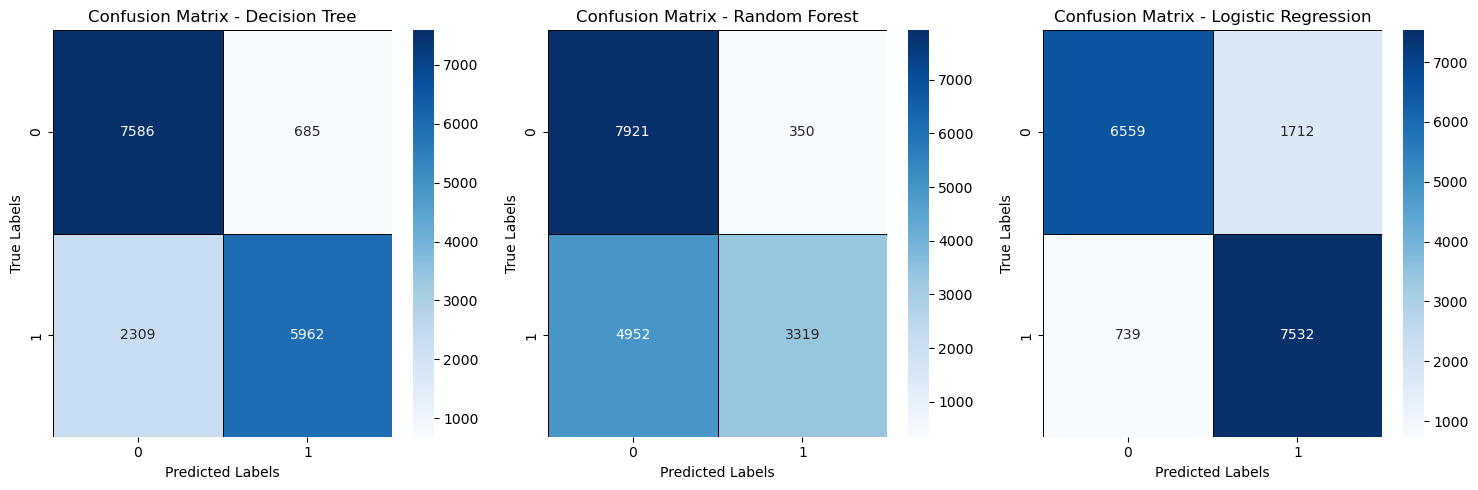

In [47]:
confusion_matrices = [dt_cm, random_cm, logistic_cm]
model_names = ["Decision Tree", "Random Forest", "Logistic Regression"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  

for i, cm in enumerate(confusion_matrices):
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='black', ax=axes[i])
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title(f'Confusion Matrix - {model_names[i]}')

plt.tight_layout()
plt.show()







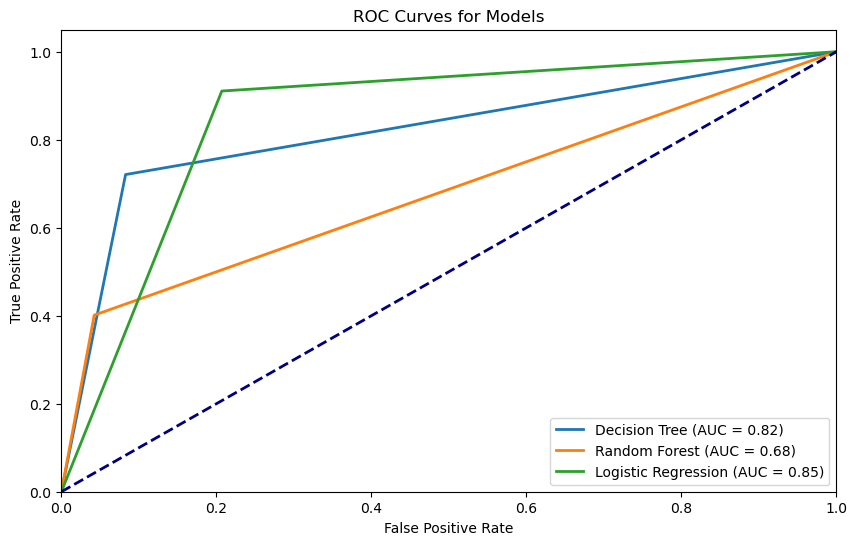

In [48]:
models = [
    ("Decision Tree", dt, dt_pred),
    ("Random Forest", random, random_pred),
    ("Logistic Regression", logistic, logistic_pred)
]

plt.figure(figsize=(10, 6))

for model_name, _, y_pred in models:
    fpr, tpr, _ = roc_curve(y_eval, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Models')
plt.legend(loc='lower right')

plt.show()

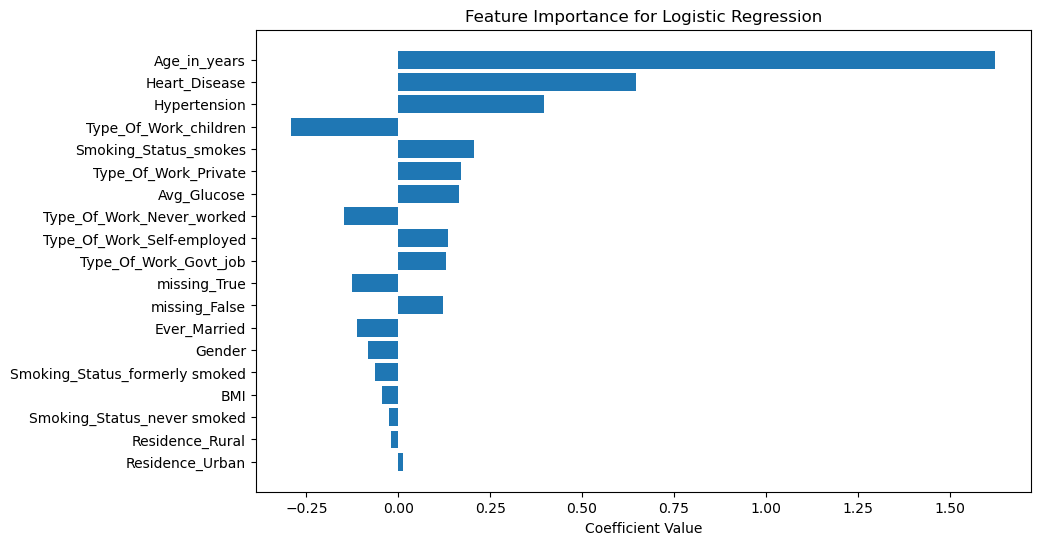

In [49]:
import numpy as np
import matplotlib.pyplot as plt

logistic_model = LogisticRegression()  # You can adjust hyperparameters if needed

logistic_model.fit(X, Y)  # Replace X and y with your feature and target data

feature_importance = logistic_model.coef_[0]

feature_names = X.columns  
sorted_idx = np.argsort(np.abs(feature_importance))
feature_names_sorted = [feature_names[i] for i in sorted_idx]
feature_importance_sorted = feature_importance[sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance_sorted)), feature_importance_sorted)
plt.yticks(range(len(feature_importance_sorted)), feature_names_sorted)
plt.xlabel('Coefficient Value')
plt.title('Feature Importance for Logistic Regression')
plt.show()
